# NF

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.DGLModel import DGLModel
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd
import torch

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST1 = Dataset.load_csv("ds/TST_1")
TST2 = Dataset.load_csv("ds/TST_2")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [5]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [6]:
RANDOM_STATE = 1234
SPACE = {
    "hidden_feats": tune.choice([[64], [64, 64], [64, 64, 64], [64, 128], [64, 128, 256]]),
    "max_degree": tune.randint(2, 15),
    "batchnorm": tune.choice([True, False]),
    "dropout": tune.uniform(0, 1),
    "lr": tune.choice([0.1, 0.01, 0.001]),
    "epoch": tune.choice([100, 150, 200, 250, 300]),
}

In [7]:
from model.dgl.NF import NF
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = NF(
        task_type="regression",
        # NF Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=config["hidden_feats"],
        max_degree=config["max_degree"],
        activation=torch.nn.functional.relu,
        batchnorm=config["batchnorm"],
        dropout=config["dropout"],
        # Abstract DGL Configuration
        lr=config["lr"],
        y_name="LogS exp (mol/L)",
        weight_decay=0,
        batch_size=4096,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
    tune.report(rmse=np.average(scores["rmse"]))

In [8]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=50,
    search_alg=BasicVariantGenerator(max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-20 16:46:11,907	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_b6373_00000,2023-03-20_16-47-35,False,,54fd22ca6a8442bbaa456e8d39251f76,64-4090-13700K,1,127.0.0.1,31400,1.63855,77.3739,77.3739,77.3739,1679330855,0,,1,b6373_00000,0.00299954


2023-03-20 17:34:21,562	INFO tune.py:798 -- Total run time: 2886.18 seconds (2886.09 seconds for the tuning loop).


In [9]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'hidden_feats': [64, 64, 64],
 'max_degree': 12,
 'batchnorm': True,
 'dropout': 0.013154749573768054,
 'lr': 0.001,
 'epoch': 250}

In [6]:
from model.dgl.NF import NF

model = NF(
    task_type="regression",
    # NF Configuration
    n_tasks=1,
    in_feats=featurizer.get_node_feat_size(),
    hidden_feats=[64, 64, 64],
    max_degree=12,
    activation=torch.nn.functional.relu,
    batchnorm=True,
    dropout=0.013154749573768054,
    # Abstract DGL Configuration
    lr=0.001,
    y_name="LogS exp (mol/L)",
    weight_decay=0,
    batch_size=4096,
    verbose=False
)

In [7]:
trn, val = TRN.split()
scores = model.fit(trn, val=val, epochs=250)

100%|██████████| 250/250 [01:34<00:00,  2.64it/s, loss: 0.322 rmse: 1.147]


<AxesSubplot: >

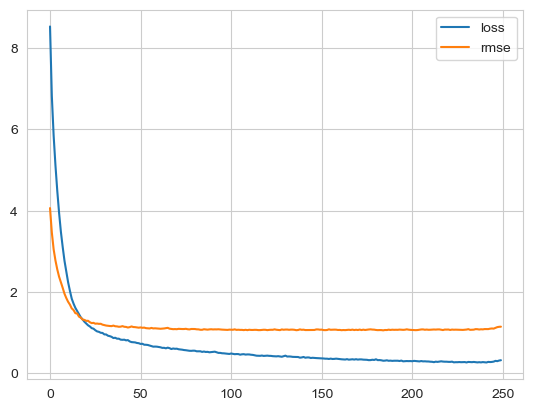

In [8]:
pd.DataFrame({
    "loss": [v.item() for v in model.scores["loss"]],
    "rmse": [v.item() for v in model.scores["rmse"]]
}).plot()

In [10]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, model.predict(TST1).cpu(), squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, model.predict(TST2).cpu(), squared=False)}")

TST1 : RMSE 1.2812614971436862
TST2 : RMSE 2.02208399588917


In [6]:
SPACE = {
    "weight_decay": tune.uniform(0, 0.5),
    "dropout": tune.uniform(0, 0.5)
}

In [7]:
from model.dgl.NF import NF
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    trn, val = dataset.split()
    model = NF(
        task_type="regression",
        # NF Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64],
        max_degree=10,
        activation=torch.nn.functional.relu,
        batchnorm=True,
        dropout=config["dropout"],
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=100, verbose=False)
    tune.report(rmse=np.average(scores["rmse"]))

In [9]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search import ConcurrencyLimiter

tuner = DGLModel.tuner(
    trainable_func,
    space=SPACE,
    num_samples=50,
    search_alg=ConcurrencyLimiter(BayesOptSearch(metric="rmse", mode="min"), max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-20 21:04:38,750	INFO tune.py:922 -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.
2023-03-20 21:04:40,597	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_97116ece,2023-03-20_21-05-33,False,,c59d6f290ca74d1999d3b8cb1105684c,64-4090-13700K,1,127.0.0.1,4008,1.94104,44.7823,44.7823,44.7823,1679346333,0,,1,97116ece,0.00429678


2023-03-20 21:50:49,295	INFO tune.py:798 -- Total run time: 2762.96 seconds (2762.87 seconds for the tuning loop).


In [10]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'weight_decay': 0.003302744322396134, 'dropout': 0.015713745299991422}

In [41]:
from model.dgl.NF import NF

AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = NF(
        task_type="regression",
        # NF Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64],
        max_degree=10,
        activation=torch.nn.functional.relu,
        batchnorm=True,
        dropout=0.015713745299991422,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.003302744322396134,
        batch_size=4096
    )
    model.fit(trn, val=val, epochs=500, min_epoch=150, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 36%|███▌      | 181/500 [01:04<01:54,  2.80it/s, loss: 0.503 rmse: 1.094]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 41%|████      | 204/500 [01:17<01:52,  2.64it/s, loss: 0.400 rmse: 1.561]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 41%|████      | 203/500 [01:20<01:57,  2.54it/s, loss: 0.395 rmse: 1.515]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 39%|███▊      | 193/500 [01:11<01:53,  2.71it/s, loss: 0.428 rmse: 0.932]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 37%|███▋      | 184/500 [01:12<02:04,  2.53it/s, loss: 0.481 rmse: 1.062]


In [42]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [43]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")

TST1 : RMSE 0.8976492801729167
TST2 : RMSE 1.5981956438181766


In [44]:
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : R^2 0.49716189095182206
TST2 : R^2 0.44315433448807395


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (NF)\nRMSE: 1.598, $R^2$: 0.443')

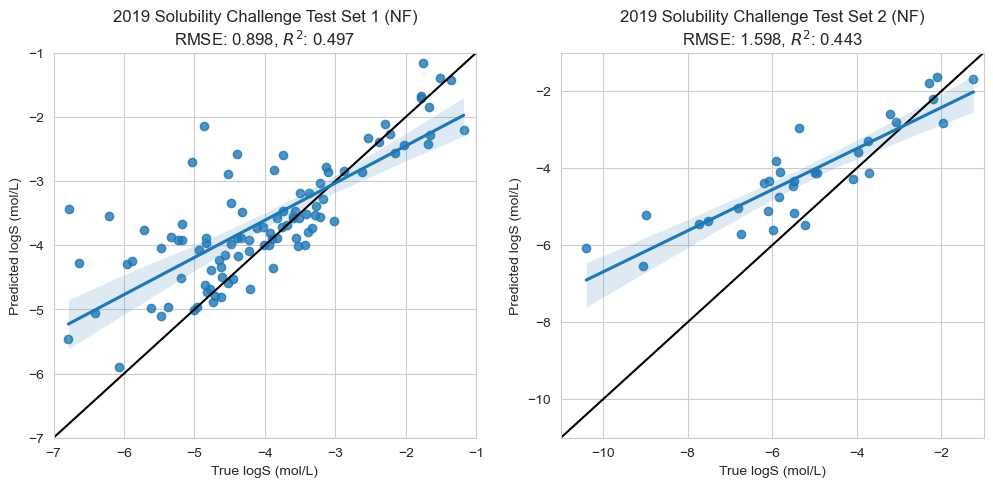

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

model_name = "NF"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")